In [1]:
%matplotlib inline

import os
import sys

import polars as pl
import pandas as pd
import numpy as np
import matplotlib as plt
import mplfinance as mpf
from tqdm import tqdm
from datetime import date, timedelta, datetime, timezone
import json

from binance_utility.plot_utils import plot_correlation

In [2]:
# 約定履歴21日分を読み込む。あらかじめdownload_trades.pyを使ってデータファイルをダウンロードしておくこと。
days = 21
symbol = "BTCUSDT"

# 指定日から30日前までのデータを使いたい場合
last_date = date(year=2023, month=5, day=5)
# 昨日から30日前までのデータを使いたい場合
# last_date = (datetime.now(timezone.utc) - timedelta(days = 2)).date()
start_date = last_date - timedelta(days=days)

if "df_trades" in globals():
    del df_trades

df_trades = None
date_cursor = start_date

while date_cursor <= last_date:
    if df_trades is None:
        df_trades = pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet")
    else:
        df_trades = df_trades.vstack(pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet"))
    date_cursor = date_cursor + timedelta(days=1)

df_trades = df_trades.with_columns([(pl.when(pl.col("side") == "a").then(-pl.col("qty")).otherwise(pl.col("qty"))).alias("qty")]).sort("timestamp")

argument is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    


In [ ]:
# タイムバー作成用パラメータ
groupby_interval_min = 15
groupby_interval_msec = groupby_interval_min * 60 * 1000

# タイムバー作成
df_timebar = df_trades.groupby_dynamic("timestamp", every=f"{int(groupby_interval_msec)}i", closed="left").agg([pl.col("price").first().alias("open"), pl.col("price").max().alias("high"), pl.col("price").min().alias("low"), pl.col("price").last().alias("close"), np.abs(pl.col("qty")).sum().alias("volume"), pl.col("qty").sum().alias("qty_sum"), (pl.col("price").std()).alias("real_sigma")])
df_timebar = df_timebar.with_columns([((pl.col("close") - pl.col("open")) / pl.col("open")).alias("pct_change_price"), (pl.col("close") - pl.col("open")).alias("delta_price")])

In [3]:
# bid / askヒット時間を計算するユーティリティ関数
# timestamp_toは含まない
def calc_hit_time(timestamp_from, timestamp_to, bid_price, ask_price):
    _bid_hit_time = np.nan
    _ask_hit_time = np.nan

    _df_trades_filtered = df_trades.filter((pl.col("timestamp") >= timestamp_from) & (pl.col("timestamp") < timestamp_to))
    _df_trades_less_than_bid_price = _df_trades_filtered.filter(pl.col("price") <= bid_price)
    if _df_trades_less_than_bid_price.shape[0] >= 1:
        _bid_hit_time = _df_trades_less_than_bid_price["timestamp"].min()
    
    _df_trades_more_than_ask_price = _df_trades_filtered.filter(pl.col("price") >= ask_price)
    if _df_trades_more_than_ask_price.shape[0] >= 1:
        _ask_hit_time = _df_trades_more_than_ask_price["timestamp"].min()
    
    return _bid_hit_time, _ask_hit_time

# Buyを実行するユーティリティ関数
def buy(q, cash, delta, position_abs_max, price, fee_rate):
    _q, _cash = q, cash
    if _q < position_abs_max:
        _delta = delta if q + delta <= position_abs_max else position_abs_max - _q
        if _cash >= _delta * price:
            _q = q + _delta
            _cash = cash - (1 + fee_rate) * _delta * price
    return _q, _cash

# Sellを実行するユーティリティ関数
def sell(q, cash, delta, position_abs_max, price, fee_rate):
    _q, _cash = q, cash
    if _q > -position_abs_max:
        _delta = delta if q - delta >= -position_abs_max else np.abs(-position_abs_max - _q)
        _q = q - _delta
        _cash = cash + (1 - fee_rate) * _delta * price
    
    return _q, _cash

{
    "A": 18.2149678240626,
    "a": 226.98638124,
    "alpha": 1.1254549,
    "b": 30.534806,
    "c": 0.01230271,
    "delta": 2,
    "gamma": 1,
    "k": 0.03685809891832947,
    "lambda": 0.0011111111111111111,
    "position_abs_max": 1
}


100%|██████████| 2112/2112 [00:07<00:00, 295.66it/s]
/opt/conda/lib/python3.10/site-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


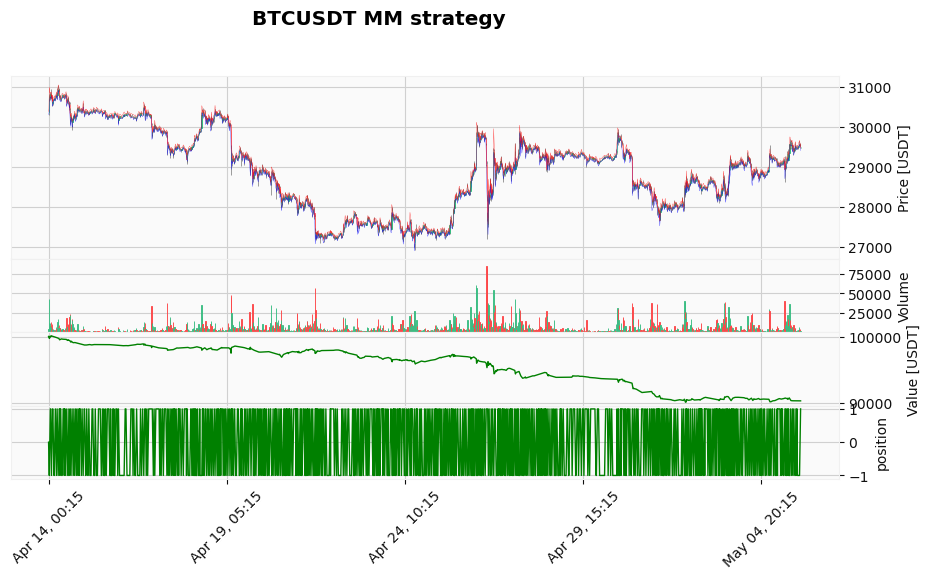

timestamp,open,high,low,close,volume,qty_sum,real_sigma,pct_change_price,delta_price,bid_price,ask_price,q,cash,value
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64
1681430400000,30362.7,30370.3,30334.1,30347.1,2340.601,-453.929,10.817258,-0.000514,-15.6,NaN,NaN,0.0,100000,0.0
1681431300000,30347.2,30409.8,30293.0,30386.7,4043.53,416.412,29.983463,0.001302,39.5,30309.085792,30385.114208,0.0,100000,100000.0
1681432200000,30386.8,30822.8,30364.7,30721.9,42852.661,6622.333,121.356643,0.011028,335.1,30329.402876,30443.997124,-1.0,130442,100056.226761
1681433100000,30721.9,30768.1,30641.8,30741.3,12533.362,-1036.196,28.412837,0.000631,19.4,30694.768921,30993.222345,-1.0,130442,99720.1
1681434000000,30741.4,30850.0,30704.9,30814.9,12591.341,1012.045,32.143596,0.002391,73.5,30714.168921,30825.602788,1.0,69040,99781.484251
1681434900000,30814.8,30830.0,30681.0,30770.9,8806.14,-887.758,36.11162,-0.001425,-43.9,30723.090258,30842.031079,-1.0,130678,99863.975334
1681435800000,30770.8,30835.4,30722.2,30817.8,8496.297,708.077,27.553911,0.001527,47.0,30743.768921,30870.694115,1.0,69219,99990.430248
1681436700000,30817.7,30950.0,30750.0,30776.4,12891.74,613.714,44.919466,-0.00134,-41.3,30735.225526,30844.931079,1.0,69219,100036.8
1681437600000,30776.3,30811.7,30711.1,30805.4,6661.243,239.439,21.93148,0.000946,29.1,30658.882924,30803.531079,-1.0,130896,100120.124186


In [33]:
# 指値幅の計算パラメータ
params = {
    "position_abs_max": 1,
    "lambda": 1 / (groupby_interval_min * 60),
    "delta": 2,
    "a": 226.98638124,
    "alpha": 1.1254549,
    "b": 3.0534806e+01,
    "c": 1.2302710e-02,
    "gamma": 1
}

params["A"] = params["lambda"] / params["alpha"] * params["a"] / params["c"]
params["k"] = params["alpha"] / params["b"]

print(json.dumps(params, indent=4, sort_keys=True))

# timebarデータフレームに計算した指値やポジション、損益を追加する
initial_cash = 100_000
fee_rate = 0.0002

df_timebar = df_timebar.with_columns([pl.lit(np.nan).alias("bid_price"), pl.lit(np.nan).alias("ask_price"), pl.lit(0.0).alias("q"), pl.lit(0).alias("cash"), pl.lit(0.0).alias("value")])
df_timebar[0, "cash"] = initial_cash

# シミュレーションの準備
_prev_row = None

# 指値幅の計算 (_qは_idxのものを使い、指値は_idx+1に入れる)
df_timebar_num_rows = df_timebar.shape[0]
for _idx in tqdm(range(0, df_timebar_num_rows)):
    # このバーが始まった時点でのポジションとキャッシュを取得
    _q = df_timebar[_idx, "q"]
    _cash = df_timebar[_idx, "cash"]
    _sigma = df_timebar[_idx, "real_sigma"]

    # 最後の行は指値幅計算をしない
    if _idx < df_timebar_num_rows - 1:
        _bid_delta = (1 / params["k"] + (2 * _q + params["delta"]) / 2 * np.sqrt((params["gamma"] * _sigma ** 2 * np.e) / (2 * params["A"] * params["delta"] * params["k"])))
        _ask_delta = (1 / params["k"] - (2 * _q - params["delta"]) / 2 * np.sqrt((params["gamma"] * _sigma ** 2 * np.e) / (2 * params["A"] * params["delta"] * params["k"])))
        #print(f"_q={_q}, _sigma={_sigma}, _bid_delta={_bid_delta}, _ask_delta={_ask_delta}")
        df_timebar[_idx + 1, "bid_price"] = df_timebar[_idx, "close"] - _bid_delta
        df_timebar[_idx + 1, "ask_price"] = df_timebar[_idx, "close"] + _ask_delta

    # 最初の行は指値幅がないのでトレードの計算をしない                                
    if _idx == 0:
        df_timebar[_idx+1, "q"] = _q
        df_timebar[_idx+1, "cash"] = _cash
        df_timebar[_idx+1, "value"] = _cash + _q * df_timebar[_idx, "close"]
        continue
    
    # _idx-1で計算され、_idxに入っている指値をもとにヒットを計算する
    _is_bid_hit = df_timebar[_idx, "bid_price"] >= df_timebar[_idx, "low"]
    _is_ask_hit = df_timebar[_idx, "ask_price"] <= df_timebar[_idx, "high"]

    if _is_bid_hit and _is_ask_hit:
        #print("buy and sell")
        _current_timestamp = df_timebar[_idx, "timestamp"]
        _bid_hit_timestamp, _ask_hit_timestamp = calc_hit_time(_current_timestamp, _current_timestamp + groupby_interval_msec, df_timebar[_idx, "bid_price"], df_timebar[_idx, "ask_price"])
        if _bid_hit_timestamp <= _ask_hit_timestamp:
            _q, _cash = buy(_q, _cash, params["delta"], params["position_abs_max"], df_timebar[_idx, "bid_price"], fee_rate)
            _q, _cash = sell(_q, _cash, params["delta"], params["position_abs_max"], df_timebar[_idx, "ask_price"], fee_rate)
        else:
            _q, _cash = sell(_q, _cash, params["delta"], params["position_abs_max"], df_timebar[_idx, "ask_price"], fee_rate)
            _q, _cash = buy(_q, _cash, params["delta"], params["position_abs_max"], df_timebar[_idx, "bid_price"], fee_rate)
    elif _is_bid_hit:
        #print("buy")
        _q, _cash = buy(_q, _cash, params["delta"], params["position_abs_max"], df_timebar[_idx, "bid_price"], fee_rate)
    elif _is_ask_hit:
        #print("sell")
        _q, _cash = sell(_q, _cash, params["delta"], params["position_abs_max"], df_timebar[_idx, "ask_price"], fee_rate)
    
    #print(f"_q = {_q}, _cash={_cash}")

    # Valueの計算などを行い、現タイムバー完了時点のタイムバーのq, cash, valueを_idx+1に代入しておく
    # 最後の行はこの計算をしない
    if _idx < df_timebar_num_rows - 1:
        df_timebar[_idx+1, "q"] = _q
        df_timebar[_idx+1, "cash"] = _cash
        df_timebar[_idx+1, "value"] = _cash + _q * df_timebar[_idx, "close"]

# 表示用データフレームの作成
df_timebar_pd = df_timebar.to_pandas().dropna()
df_timebar_pd["datetime"] = pd.to_datetime(df_timebar_pd["timestamp"], unit="ms")
df_timebar_pd = df_timebar_pd.set_index("datetime", drop = True)
df_timebar_pd_filtered = df_timebar_pd

# プロット
additional_plot = [mpf.make_addplot(df_timebar_pd_filtered["value"], type="line", color="green", ylabel="Value [USDT]", width=1, panel=2),
                   mpf.make_addplot(df_timebar_pd_filtered["q"], type="line", color="green", ylabel="position", width=1, panel=3),
                   mpf.make_addplot(df_timebar_pd_filtered["bid_price"], type="line", color="blue", width=0.2),
                   mpf.make_addplot(df_timebar_pd_filtered["ask_price"], type="line", color="red", width=0.2)]
mpf.plot(df_timebar_pd_filtered, type="candle", title=f"{symbol} MM strategy", ylabel="Price [USDT]", style="yahoo", figratio=(12, 6), addplot = additional_plot, volume=True)
display(df_timebar)

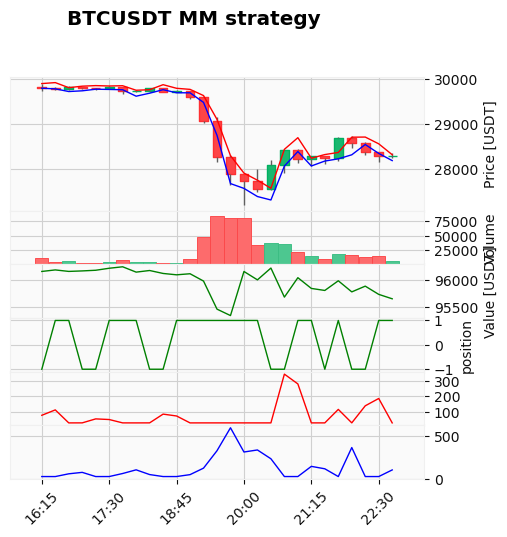

In [34]:
df_timebar_pd_filtered = df_timebar_pd[(df_timebar_pd.index > "2023-04-26 16:00:00") & (df_timebar_pd.index < "2023-04-26 23:00:00")]
additional_plot = [mpf.make_addplot(df_timebar_pd_filtered["value"], type="line", color="green", ylabel="Value [USDT]", width=1, panel=2),
                   mpf.make_addplot(df_timebar_pd_filtered["q"], type="line", color="green", ylabel="position", width=1, panel=3),
                   mpf.make_addplot(df_timebar_pd_filtered["bid_price"], type="line", color="blue", width=1),
                   mpf.make_addplot(df_timebar_pd_filtered["ask_price"], type="line", color="red", width=1),
                   mpf.make_addplot(df_timebar_pd_filtered["ask_price"] - df_timebar_pd_filtered["open"], type="line", color="red", width=1, panel=4),
                   mpf.make_addplot(-df_timebar_pd_filtered["bid_price"] + df_timebar_pd_filtered["open"], type="line", color="blue", width=1, panel=5)]

mpf.plot(df_timebar_pd_filtered, type="candle", title=f"{symbol} MM strategy", ylabel="Price [USDT]", style="yahoo", figratio=(16, 16), addplot = additional_plot, volume=True)